In [3]:
!pip install open3d matplotlib
!pip install trimesh
!pip install pyrender
%env SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True
%pip install mesh-to-sdf
!pip install opencv-python

env: SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/d9/64/7fdfb9386511cd6805451e012c537073a79a958a58795c4e602e538c388c/opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 55.5 MB/s eta 0:00:00:00:0100:01


In [4]:
pose_file="/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/processedData/traj.txt"

#/home/koerner/Project/nice-slam/output/Own/room0/mesh/00990_mesh_color.ply
#/home/koerner/Project/nice-slam/Datasets/Replica/room0_mesh.ply
#/home/koerner/Project_Dogu/nice-slam/DataSetEval/room0_mesh.obj
#/home/koerner/Project_Dogu/nice-slam/DataSetEval/final_mesh_eval_rec.obj

import trimesh
import pyrender
import skimage
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import math
import sys
import cv2

# Added Psnr

In [6]:
'''try:
    mesh = trimesh.load(ply_file)
except Exception as e:
    print(f"Error loading mesh: {e}")
'''
os.environ['PYOPENGL_PLATFORM'] = 'egl'

def PSNR(color1, color2):
    mse = np.mean((color1 - color2) ** 2)
    psnrScore=20 * np.log10(255.0 / np.sqrt(mse))
    #print("Psnr score",psnrScore)
    return psnrScore

# UPDATE Trajectories

In [7]:
from IPython.display import Image
Image(filename='Rotation.png',width=200, height=500) 

FileNotFoundError: [Errno 2] No such file or directory: 'Rotation.png'

In [8]:

rotation_matrix_x_4x4= np.array([[1, 0, 0, 0],
                                 [0, 0, 1, 0],
                                 [0, -1, 0, 0],
                                 [0, 0, 0, 1]])

rotation_matrix_y= np.array([[0, 0, -1, 0],
                            [0, 1, 0, 0],
                            [1, 0, 0, 0],
                            [0, 0, 0, 1]])

rotation_matrix_z= np.array([[0, -1, 0, 0],
                             [1, 0, 0, 0],
                             [0, 0, 1, 0],
                             [0, 0, 0, 1]])

rotation_matrix_x_3x3= np.array([[1, 0, 0],
                                 [0, 0, 1],
                                 [0, -1, 0]])

rotation_matrix_y_3x3= np.array([[0, 0, -1],
                                 [0, 1, 0],
                                 [1, 0, 0]])

rotation_matrix_z_3x3= np.array([[0, -1, 0],
                             [1, 0, 0],
                             [0, 0, 1]])
def customRot_z_3x3(angle):
    return np.array([[math.cos(2*np.pi*(angle)/360), -math.sin(2*np.pi*(angle)/360),0],
                     [math.sin(2*np.pi*(angle)/360),math.cos(2*np.pi*(angle)/360) ,0 ],
                     [0, 0, 1]])


In [9]:
'''def Thc_to_Twc(T_hc):  # habitat-caemra to habitat world transformation --->  opencv-camera to world transformation
    T_wh, T_hw = habitat_world_transformations()
    T_wc = T_wh @ T_hc @ opencv_to_opengl_camera()
    return T_wc'''
def opencv_to_opengl_camera(T_wc):
    return rotation_matrix_x_4x4@rotation_matrix_x_4x4@T_wc

T_wc = np.loadtxt(pose_file).reshape(-1, 4, 4)
T_wc = opencv_to_opengl_camera(T_wc)
#T_wc[:,1:3] *= -1
trajectories = [T_wc[i] for i in range(T_wc.shape[0])]
print("Trajectories",trajectories[0])

Trajectories [[ 0.63281906  0.5936474  -0.4971145   0.39389375]
 [-0.03214595  0.6616073   0.7491611  -0.06876414]
 [ 0.7736321  -0.45810315  0.43776107 -0.6076599 ]
 [ 0.          0.          0.          1.        ]]



#### From bounds [-2.9,8.9],[-3.2,5.5],[-3.5,3.3] room0.yaml
 (8.9-2.9) /2=11.8 x coordinate for middle of the room <br>
 (5.5-3.2) /2=1.15 y coordinate for middle of the room <br>
 (3.3-3.5) /2=-0.15 z coordinate for middle of the room <br>
  the camera looks at the middle of the room downwards thorough z axis <br>
 y axis to the left side of the camera rotation 90 degrees to the window<br>
<br>
np.array([<br>
    [1, 0, 0, 3],<br>
    [0, 1, 0, 1.15],<br>
    [0, 0, 1, 0],<br>
    [0, 0, 0, 1],<br>
])<br>
<br>
ROTATION AXIS z After the transformations looks downwards:<br>
Do 360 with the z axis it should be fine


#### From bounds [-7.0,2.8],[-4.6,4.3],[-3.0,2.9] room1.yaml

In [10]:

#ourMeshRoom0 = trimesh.load('/home/koerner/Project_Dogu/nice-slam/DataSetEval/final_mesh_eval_rec.obj')
gtMeshRoom0 = trimesh.load('/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/scans/mesh_aligned_0.05.ply')
gtMeshPyRoom0 = pyrender.Mesh.from_trimesh(gtMeshRoom0)
'''

ourMeshRoom1 = trimesh.load('/home/koerner/Project_Dogu/nice-slam/data_generation/comparisonMeshes/room1OurSeg.ply')
gtMeshRoom1 = trimesh.load('/home/koerner/Project_Dogu/nice-slam/data_generation/comparisonMeshes/room1_mesh.ply')
ourMeshRoom1.invert()
ourMeshRoom1 = pyrender.Mesh.from_trimesh(ourMeshRoom1)
gtMeshPyRoom1 = pyrender.Mesh.from_trimesh(gtMeshRoom1)

ourMeshOffice0=trimesh.load("/home/koerner/Project/nice-slam/output/Own/office0/mesh/final_mesh_color.ply")
gtMeshOffice0 = trimesh.load('/home/koerner/Project_Dogu/Replica-Dataset/dataset/office_0/mesh.ply')
ourMeshOffice0.invert()
ourMeshOffice0 = pyrender.Mesh.from_trimesh(ourMeshOffice0)
gtMeshOffice0 = pyrender.Mesh.from_trimesh(gtMeshOffice0)

'''
'''
ourMeshOffice1=trimesh.load("/home/koerner/Project/nice-slam/output/Own/office1/mesh/final_mesh_color.ply")
gtMeshOffice1 = trimesh.load('/home/koerner/Project_Dogu/Replica-Dataset/dataset/office_1/mesh.ply')
ourMeshOffice1.invert()
ourMeshOffice1 = pyrender.Mesh.from_trimesh(ourMeshOffice1)
gtMeshOffice1 = pyrender.Mesh.from_trimesh(gtMeshOffice1)
'''
'''

ourMeshOffice2=trimesh.load("/home/koerner/Project/nice-slam/output/Own/office2/mesh/final_mesh_color.ply")
gtMeshOffice2 = trimesh.load('/home/koerner/Project_Dogu/Replica-Dataset/dataset/office_2/mesh.ply')
ourMeshOffice2.invert()
ourMeshOffice2 = pyrender.Mesh.from_trimesh(ourMeshOffice2)
gtMeshOffice2 = pyrender.Mesh.from_trimesh(gtMeshOffice2)


ourMeshOffice3=trimesh.load("/home/koerner/Project/nice-slam/output/Own/office3/mesh/final_mesh_color.ply")
gtMeshOffice3 = trimesh.load('/home/koerner/Project_Dogu/Replica-Dataset/dataset/office_3/mesh.ply')
ourMeshOffice3.invert()
ourMeshOffice3 = pyrender.Mesh.from_trimesh(ourMeshOffice3)
gtMeshOffice3 = pyrender.Mesh.from_trimesh(gtMeshOffice3)
'''
middleRoom0 = np.array([
    [1, 0, 0, 3],
    [0, 1, 0, 1.15],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
])
#[-7.0,2.8],[-4.6,4.3],[-3.0,2.9]
middleRoom1 = np.array([
    [1, 0, 0, -2.36],
    [0, 1, 0, -0.3],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
])

middleOffice0 = np.array([[1, 0, 0, 0.2],
                         [0, 1, 0, 0.15],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])

middleOffice1 = np.array([[1, 0, 0, 0.6],
                         [0, 1, 0, 0.45],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])

middleOffice2 = np.array([[1, 0, 0, -0.2],
                         [0, 1, 0, 1.25],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])


middleOffice3 = np.array([[1, 0, 0, -0.8],
                         [0, 1, 0, -1.3],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])


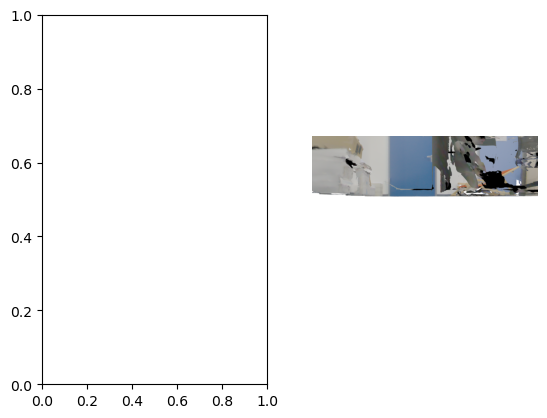

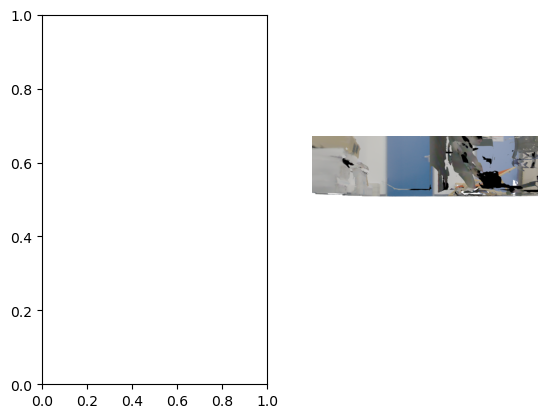

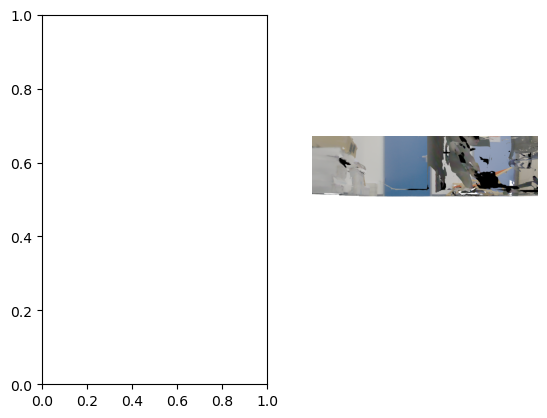

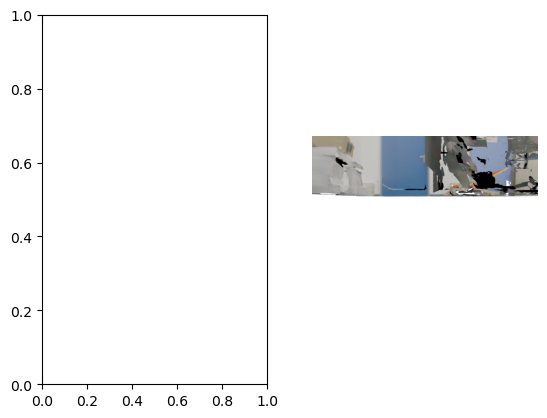

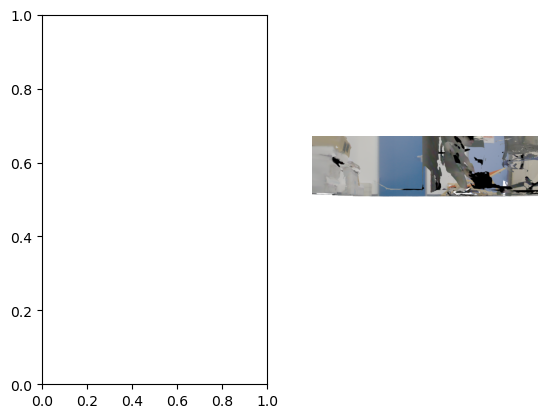

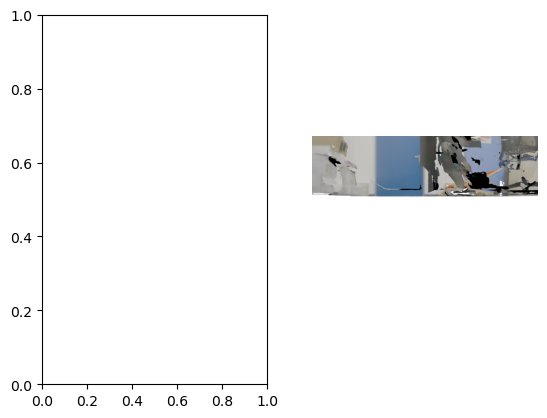

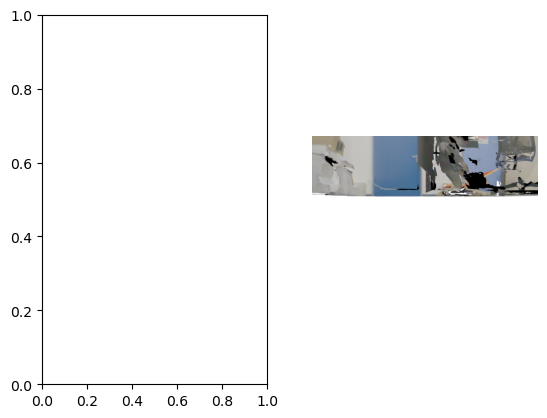

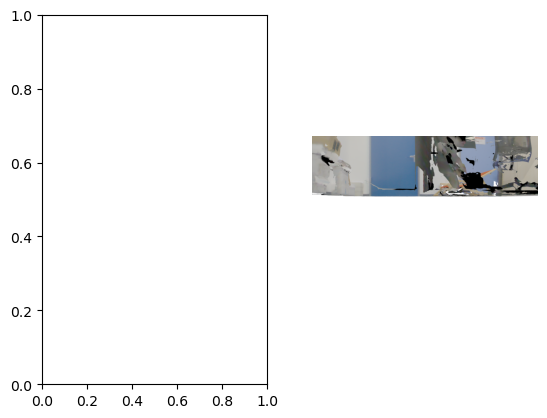

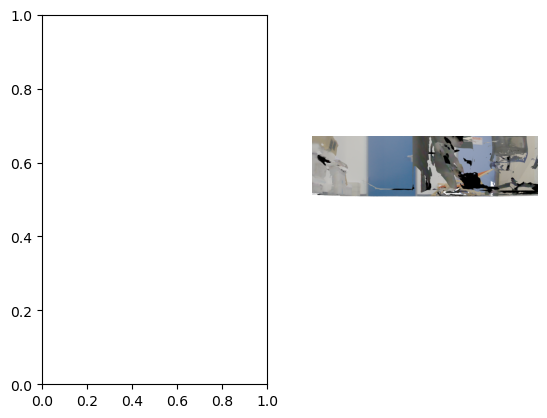

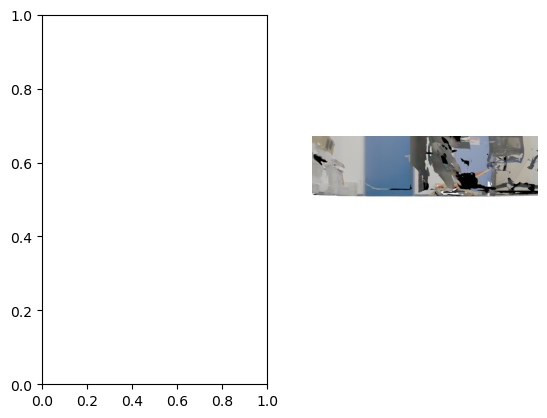

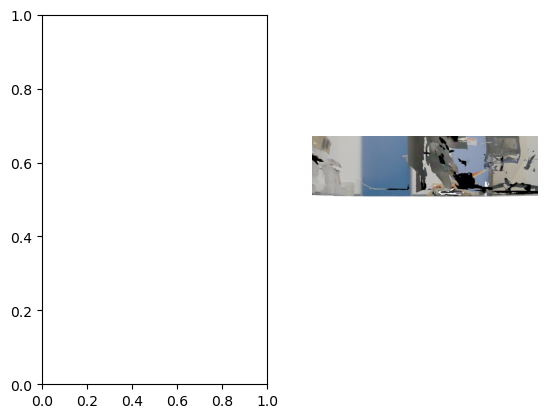

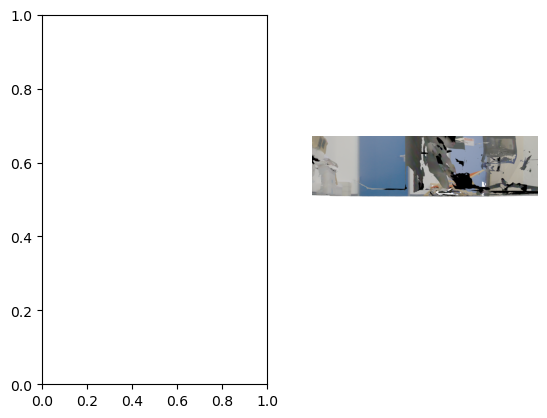

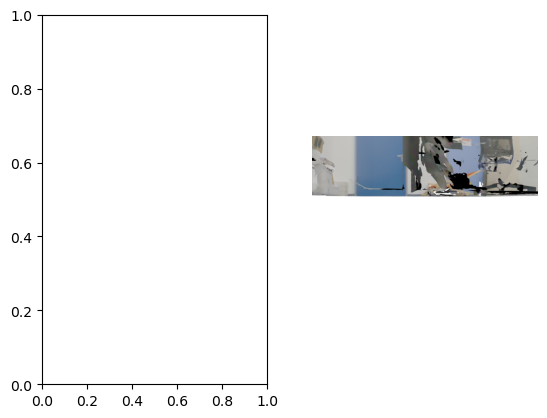

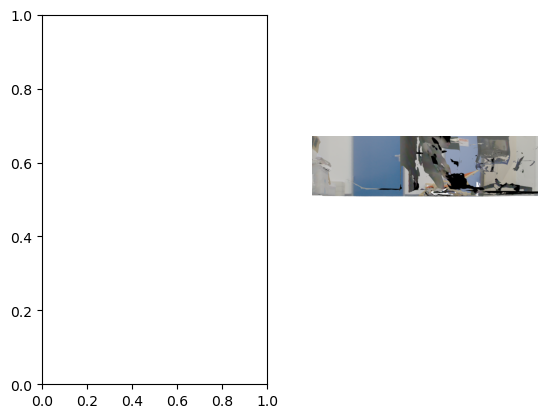

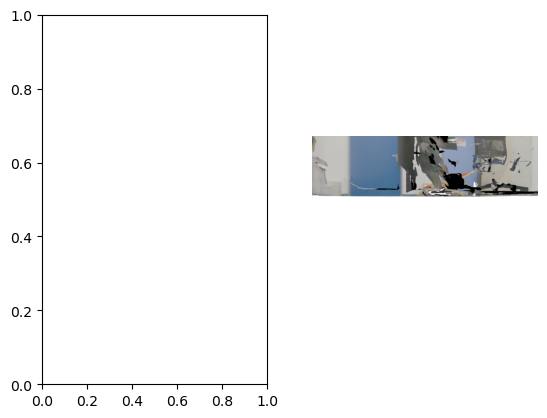

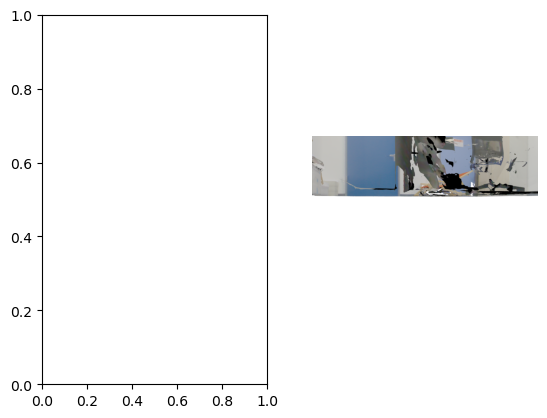

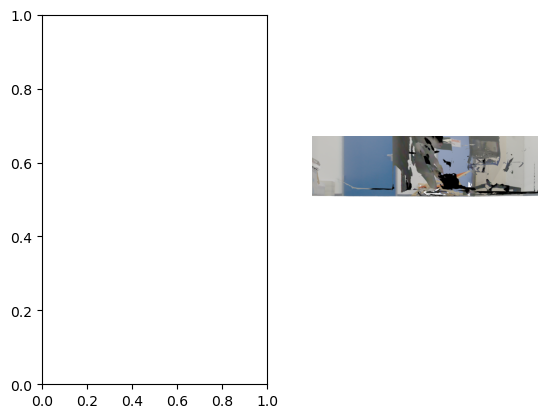

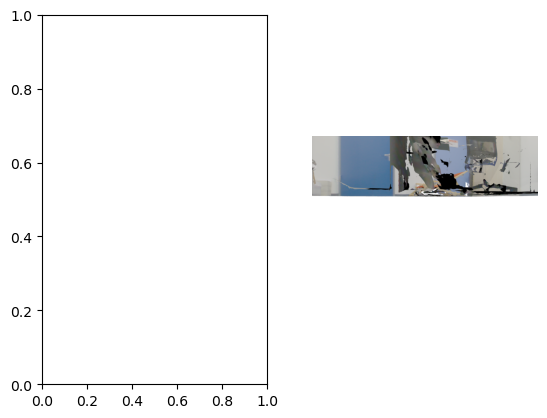

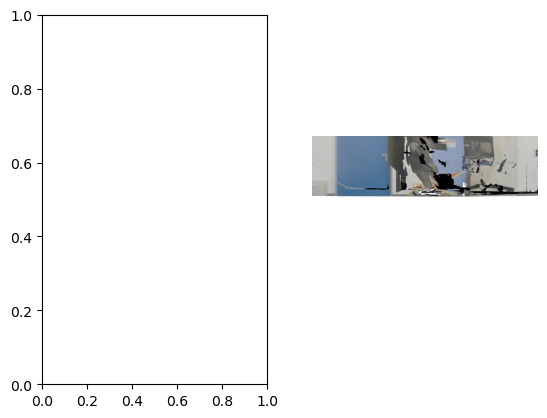

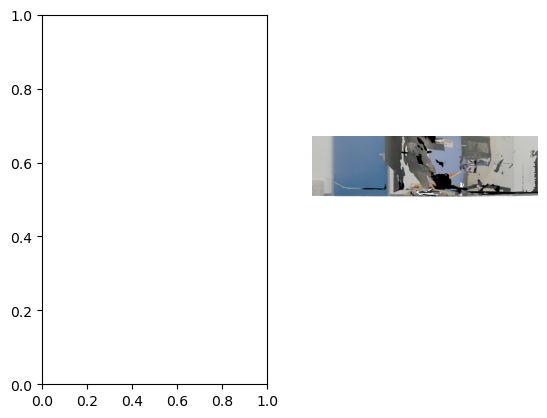

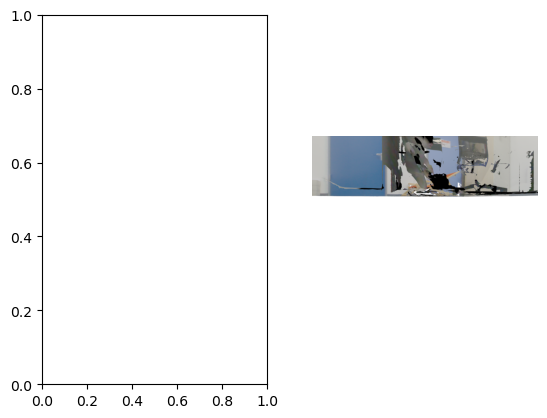

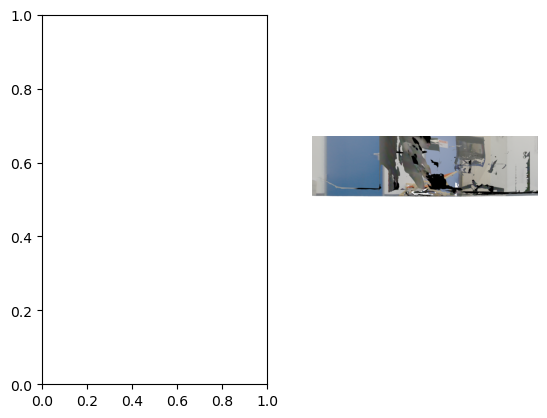

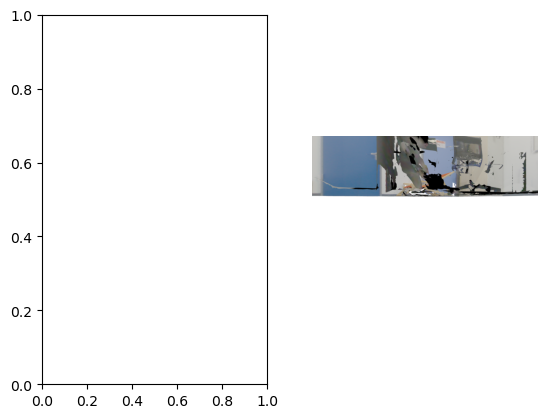

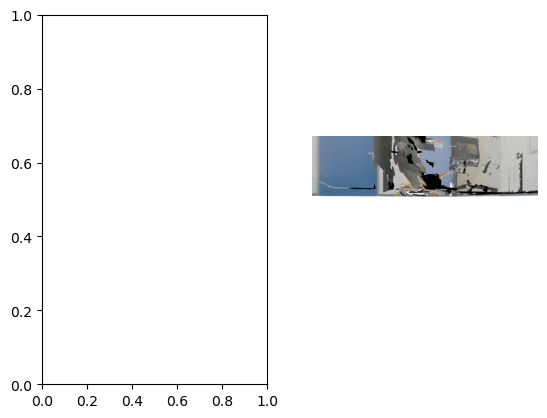

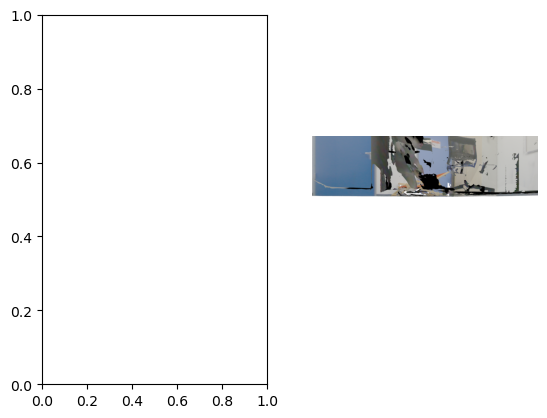

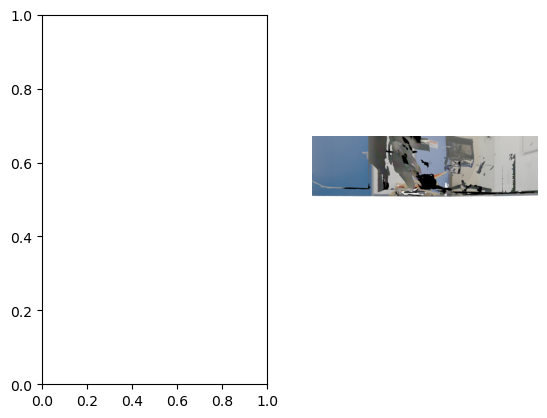

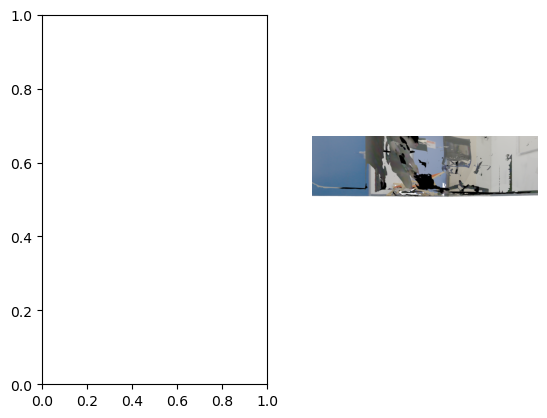

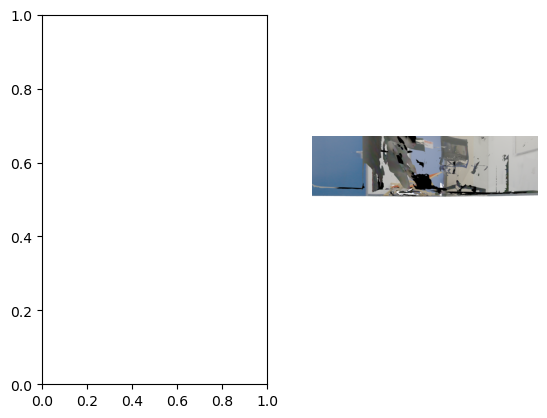

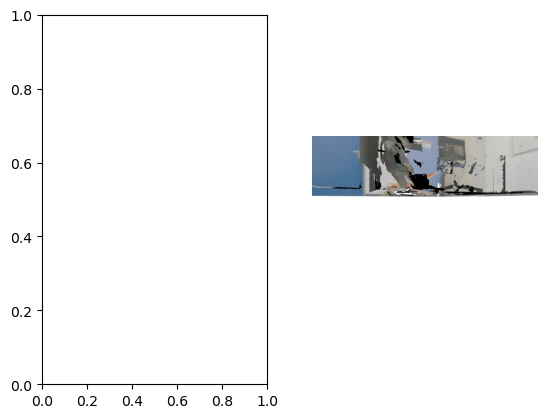

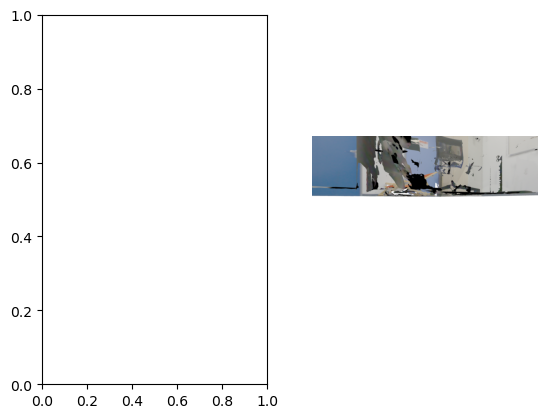

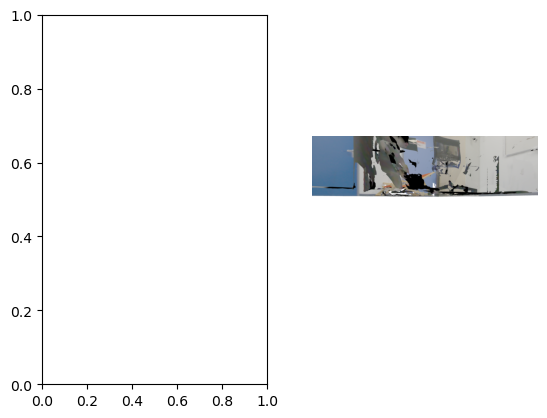

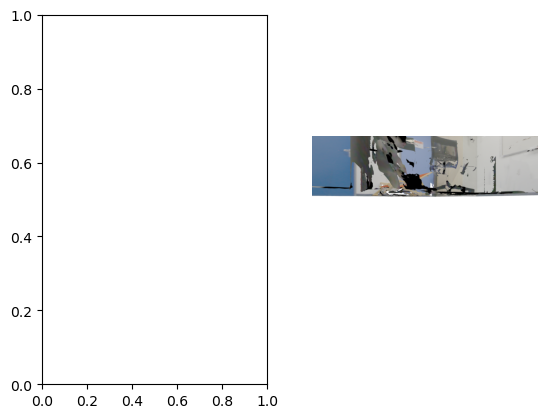

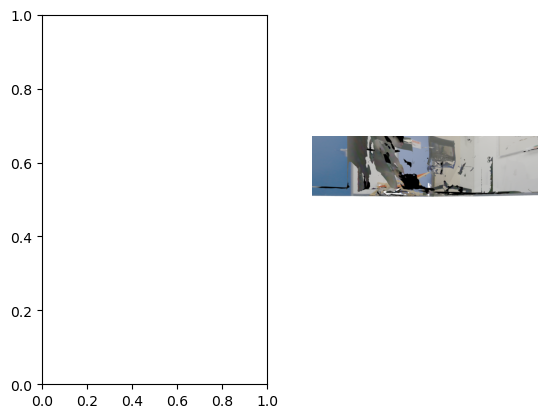

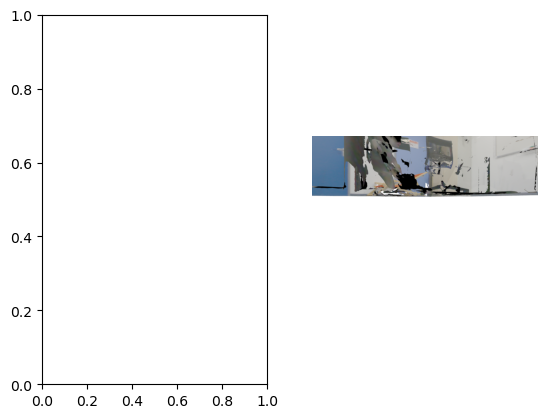

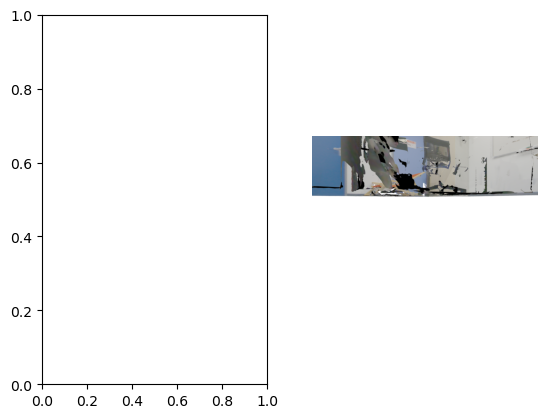

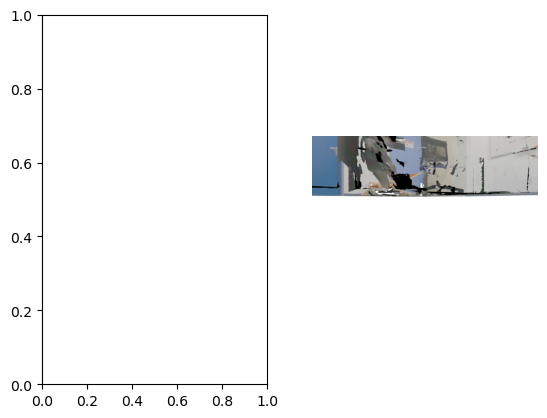

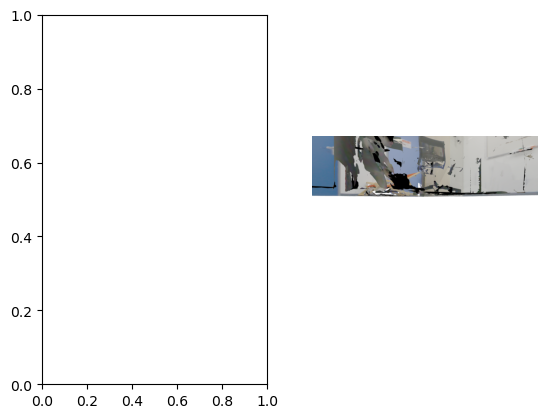

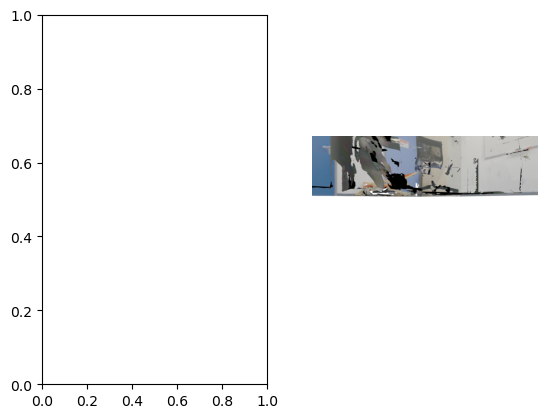

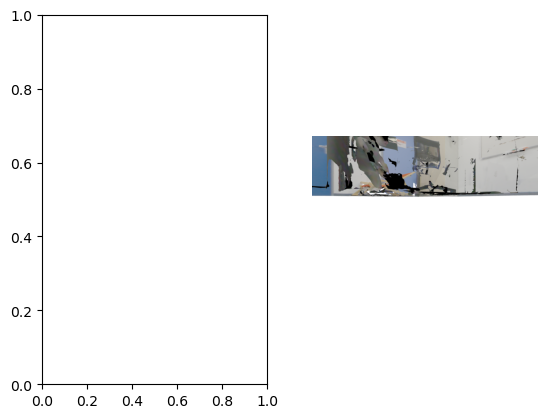

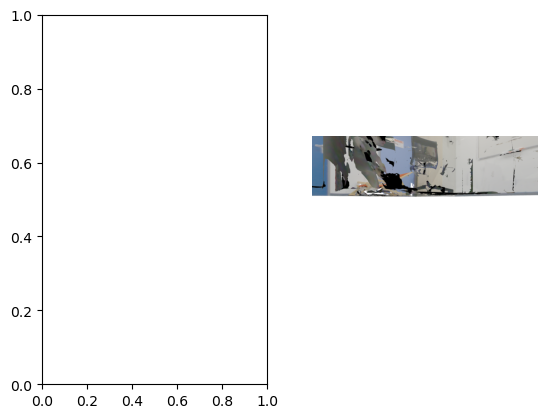

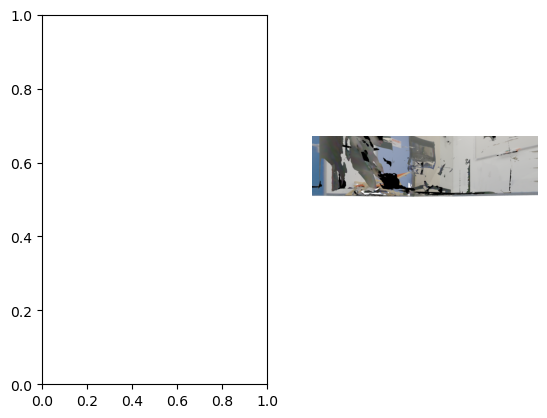

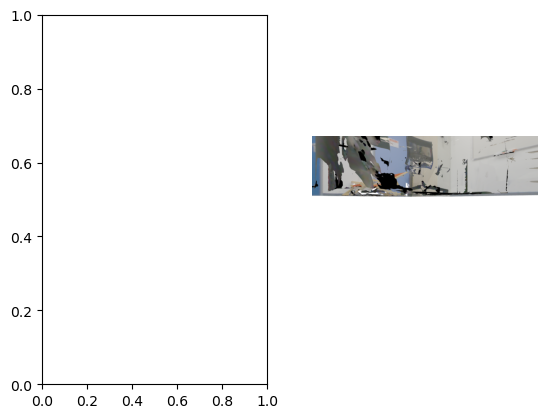

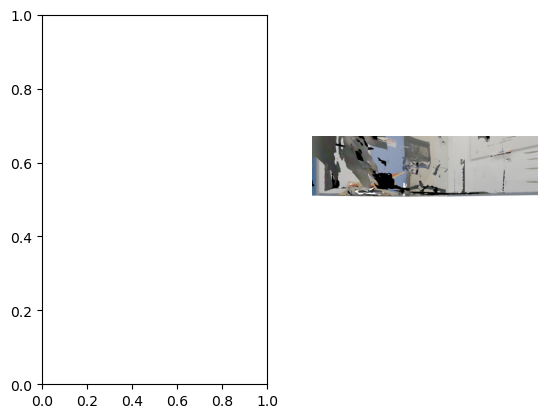

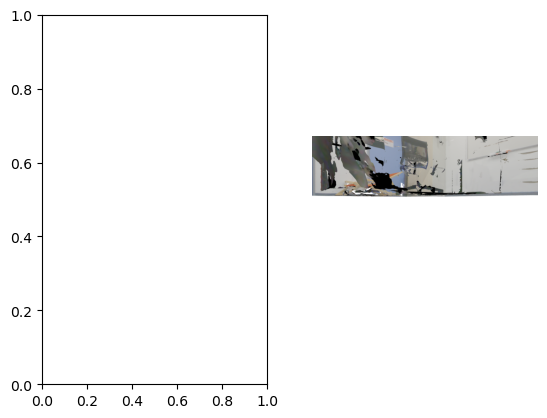

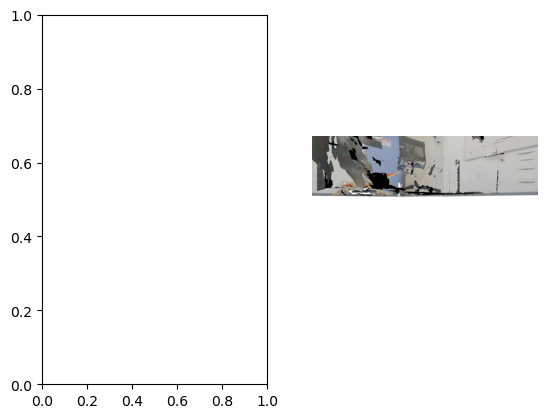

KeyboardInterrupt: 

In [11]:

#middle[0:3,0:3]=rotation_matrix_y_3x3
# z axis rotation
def psnr360(room):
    if room==0:
        gtMeshPy=gtMeshPyRoom0
        middle=middleRoom0
    ''' 
    if room==1:
        ourMesh=ourMeshRoom1
        gtMeshPy=gtMeshPyRoom1
        middle=middleRoom1
    
    if room==2:
        ourMesh=ourMeshOffice0
        gtMeshPy=gtMeshOffice0
        middle=middleOffice0
    if room==3:
        ourMesh=ourMeshOffice2
        gtMeshPy=gtMeshOffice2
        middle=middleOffice2   
    if room==4:
        ourMesh=ourMeshOffice3
        gtMeshPy=gtMeshOffice3
        middle=middleOffice3
    '''
    psnr=np.zeros(360)
    for i in range(359,-1,-1):
        gtScene = pyrender.Scene(ambient_light= [0.8,0.8,0.8, 1.0])
        
        gtScene.add(gtMeshPy)
        
        camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.4)
        s = np.sqrt(2)/2

        middle[0:3,0:3] = customRot_z_3x3(i)@rotation_matrix_y_3x3.T@rotation_matrix_z_3x3
        camera_pose = middle
        
        gtScene.add(camera, pose=camera_pose)
        

        r = pyrender.OffscreenRenderer(1200, 680, point_size=1.0)
        
        colorGt, depthGt = r.render(gtScene)
        
        f, axarr = plt.subplots(1,2)

        axarr[1].imshow(colorGt)
        axarr[1].axis('off')  # Remove axes for first subplot
        plt.show()
        
        r.delete()  # Release resources
        gtScene =None
    psnr=np.mean(psnr)
    return psnr
#for i in range(5):
    
print("Room: ",3," Psnr: ",psnr360(0))



# Load the mesh using trimesh
ply_file = ply_file  # Replace with your .ply file path
mesh = trimesh.load(ply_file)
vertices = np.asarray(mesh.vertices)
faces = np.asarray(mesh.faces)

# Load your 4x4 matrices representing the trajectory
pose_file =pose_file  # Replace with your pose file path

# Set up the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh (simple wireframe)
ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces, linewidth=0.2, antialiased=True)

for idx, mat in enumerate(trajectories):
    # Extract camera position from the matrix
    camera_position = mat[:3, 3]
    ax.axis('off')
    # Set the camera position
    ax.view_init(azim=camera_position[0], elev=camera_position[1])

    # Save the image
    plt.savefig(f'image_{idx}.png')

plt.close()
